In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib tk

In [2]:
base = Path("H:/Outros computadores/My Computer/Desktop/5 Experimento/3-Microphone")
archivo = base / "T5_3M_T7_AR_4.169m.csv"
df = pd.read_csv(archivo)

In [3]:
c_teorical = [138.07, 114.79, 95.36, 91.07, 84.24, 80.43, 75.70, 69.34, 64.78, 56.12, 53.45]

In [11]:
time = df['Time (s)'].values
time_mask = (time >= 0) & (time <= 27)
p1 = df['Channel 0'].values[time_mask]
p2 = df['Channel 1'].values[time_mask]
p3 = df['Channel 2'].values[time_mask]

In [12]:
D = 0.0044
L = 1.5 * D
fs = 100000

In [13]:
def complex_fft(sig, fs):
    w = np.hanning(len(sig))
    sigw = sig * w
    N = len(sigw)
    P = fft(sigw)
    f = fftfreq(N, 1/fs)
    pos = f > 0
    return f[pos], P[pos]

xf, P1 = complex_fft(p1, fs)
_,  P2 = complex_fft(p2, fs)
_,  P3 = complex_fft(p3, fs)

In [14]:
H = (P1 + P3) / (2.0 * P2)
H_mag = np.abs(H)
H_real = np.real(H)

In [15]:
cutoff_freq = 20000
nyquist = fs / 2
b, a = signal.butter(4, cutoff_freq/nyquist, 'low')
H_filt = signal.filtfilt(b, a, H_real)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
H_filt = H_filt.reshape(-1, 1)
H_norm = scaler.fit_transform(H_filt).flatten()

In [16]:
plt.figure(figsize=(10,5))
plt.plot(xf, H_filt, linewidth=0.8, color='black')
plt.xlabel('Frequency[Hz]', fontsize=20)
plt.ylabel('H(f) (real)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()

In [17]:
plt.figure(figsize=(10,5))
plt.plot(xf, np.abs(H_filt), linewidth=0.8, color='black')
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('|H(f)|', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()

In [ ]:
freq_mask = (xf > 0) & (xf <= 50000)
xf_valid = xf[freq_mask]
H_norm_valid = H_norm[freq_mask]

high_H_mask = np.abs(H_norm_valid) > 0.6
high_H_freqs = xf_valid[high_H_mask]
high_H_values = H_norm_valid[high_H_mask]

In [ ]:
c_conf_values = []
valid_freqs = []
valid_H_values = []

In [ ]:
for i, freq in enumerate(xf_valid):
    H_val = H_norm_valid[i]
    H_val_clipped = np.clip(H_val, -1.0 + 1e-10, 1.0 - 1e-10)

    try:
        # c_conf = ωL / arccos(H)
        omega = 2 * np.pi * freq
        c_conf = (omega * L) / np.arccos(H_val_clipped)

        # Filtrar valores razonables (50-1500 m/s)
        if 40 < c_conf < 140:
            c_conf_values.append(c_conf)
            valid_freqs.append(freq)
            valid_H_values.append(H_val)
    except:
        continue

In [ ]:
if c_conf_values:
    c_conf_median = np.median(c_conf_values)
    c_conf_mean = np.mean(c_conf_values)
    c_conf_std = np.std(c_conf_values)

    c_conf_final = c_conf_median

In [ ]:
print("=" * 70)
print(f"Puntos válidos encontrados: {len(c_conf_values)}")
print(f"Velocidad del sonido confinada (c_conf): {c_conf_final:.2f} m/s")
print(f"Mediana: {c_conf_median:.2f} m/s")
print(f"Media: {c_conf_mean:.2f} m/s")
print(f"Desviación estándar: ±{c_conf_std:.2f} m/s")
print(f"IQR: {c_conf_iqr:.2f} m/s")
print(f"Rango: {np.min(c_conf_values):.1f} - {np.max(c_conf_values):.1f} m/s")
print("=" * 70)

In [ ]:
print("Algunos valores representativos de c_conf:")
sample_indices = np.linspace(0, len(c_conf_values)-1, min(5, len(c_conf_values)), dtype=int)
for idx in sample_indices:
    print(f"f = {valid_freqs[idx]:6.1f} Hz, H = {valid_H_values[idx]:6.3f}, c = {c_conf_values[idx]:6.1f} m/s")

In [ ]:
c_teorical_avg = c_teorical[6]
error_percent = abs(c_conf_final - c_teorical_avg) / c_teorical_avg * 100
print(f"Valor teórico: {c_teorical_avg:.2f} m/s")
print(f"Error relativo: {error_percent:.1f}%")
print("=" * 70)

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15, 6))

# Gráfica de H filtrada

ax1.plot(xf_valid, H_norm_valid, 'r-', alpha=0.8, linewidth=1.5, label='H Normalizada (sklearn)')
ax1.set_xlabel('Frecuencia [Hz]')
ax1.set_ylabel('H(ω)')
ax1.set_title('Función H(ω) = (P₁ + P₃)/(2·P₂)')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(-1.2, 1.2)


print("\n" + "=" * 70)
print("RESULTADO FINAL")
print("=" * 70)
print(f"Velocidad del sonido confinada estimada: {c_conf_final:.2f} m/s")
print(f"Basado en {len(c_conf_values)} mediciones válidas")
print("=" * 70)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from pathlib import Path
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler

# Load data
base = Path("H:/Outros computadores/My Computer/Desktop/5 Experimento/3-Microphone")
archivo = base / "T5_3M_T5_AR_4.147m.csv"
df = pd.read_csv(archivo)

c_teorical = [138.07, 114.79, 95.36, 91.07, 84.24, 80.43, 75.70, 69.34, 65.54, 64.78, 56.12, 53.45]

time = df['Time (s)'].values
time_mask = (time >= 18) & (time <= 20.5)
p1 = df['Channel 0'].values[time_mask]
p2 = df['Channel 1'].values[time_mask]
p3 = df['Channel 2'].values[time_mask]

D = 0.0044
L = 1.5 * D
fs = 100000

def complex_fft(sig, fs):
    w = np.hanning(len(sig))
    sigw = sig * w
    N = len(sigw)
    P = fft(sigw)
    f = fftfreq(N, 1 / fs)
    pos = f > 0
    return f[pos], P[pos]

xf, P1 = complex_fft(p1, fs)
_, P2 = complex_fft(p2, fs)
_, P3 = complex_fft(p3, fs)

H = (P1 + P3) / (2.0 * P2)
H_real = np.real(H)
H_real = np.abs(H_real)

cutoff_freq = 20000
nyquist = fs / 2
b, a = signal.butter(4, cutoff_freq / nyquist, 'low')
H_norm = signal.filtfilt(b, a, H_real)

freq_mask = (xf > 0) & (xf <= 3500)
xf_valid = xf[freq_mask]
H_norm_valid = H_norm[freq_mask]

# ADJUSTABLE PARAMETERS
PEAK_TYPE = 'max'          # 'min' for minima, 'max' for maxima
THRESHOLD = 0.0        # Threshold (can be positive or negative)
C_CONF_RANGE = (40, 140)   # Acceptable c_conf range

if PEAK_TYPE == 'min':
    # Find minima
    peaks, properties = signal.find_peaks(-H_norm_valid, height=-THRESHOLD, prominence=0.3, distance=10)
    peak_freqs = xf_valid[peaks]
    peak_H_values = H_norm_valid[peaks]
    peak_label = 'Minima'

elif PEAK_TYPE == 'max':
    # Find maxima
    peaks, properties = signal.find_peaks(H_norm_valid, height=THRESHOLD, prominence=0.3, distance=10)
    peak_freqs = xf_valid[peaks]
    peak_H_values = H_norm_valid[peaks]
    peak_label = 'Maxima'
else:
    # Take all points exceeding the absolute threshold
    if THRESHOLD >= 0:
        mask = H_norm_valid > THRESHOLD
    else:
        mask = H_norm_valid < THRESHOLD
    peak_freqs = xf_valid[mask]
    peak_H_values = H_norm_valid[mask]
    peak_label = f'Points H {"＞" if THRESHOLD >= 0 else "＜"} {THRESHOLD}'

# Filter points that meet the threshold criterion
if PEAK_TYPE in ['min', 'max']:
    if THRESHOLD >= 0:
        valid_mask = peak_H_values > THRESHOLD
    else:
        valid_mask = peak_H_values < THRESHOLD
    selected_freqs = peak_freqs[valid_mask]
    selected_H = peak_H_values[valid_mask]
else:
    selected_freqs = peak_freqs
    selected_H = peak_H_values

c_conf_values = []
valid_freqs = []
valid_H_values = []

for i, freq in enumerate(selected_freqs):
    H_val = selected_H[i]
    H_val_clipped = np.clip(H_val, -1.0 + 1e-10, 1.0 - 1e-10)

    try:
        # c_conf = ωL / arccos(H)
        omega = 2 * np.pi * freq
        c_conf = (omega * L) / np.arccos(H_val_clipped)

        # Filter by c_conf range
        if C_CONF_RANGE[0] < c_conf < C_CONF_RANGE[1]:
            c_conf_values.append(c_conf)
            valid_freqs.append(freq)
            valid_H_values.append(H_val)
    except:
        continue

if c_conf_values:
    c_conf_median = np.median(c_conf_values)
    c_conf_mean = np.mean(c_conf_values)
    c_conf_std = np.std(c_conf_values)
    c_conf_iqr = np.percentile(c_conf_values, 75) - np.percentile(c_conf_values, 25)
    c_conf_final = c_conf_mean

print("=" * 80)
print("c_conf CALCULATION - CURRENT CONFIGURATION")
print("=" * 80)
print(f"Point type: {PEAK_TYPE}")
print(f"Threshold: {THRESHOLD}")
print(f"c_conf range: {C_CONF_RANGE[0]}-{C_CONF_RANGE[1]} m/s")
print(f"Points found: {len(selected_freqs)}")
print(f"Points producing valid c_conf: {len(c_conf_values)}")

if c_conf_values:
    print(f"\nCONFINED SOUND VELOCITY:")
    print(f"Average (mean): {c_conf_mean:.2f} m/s")
    print(f"Median: {c_conf_median:.2f} m/s")
    print(f"Standard deviation: ±{c_conf_std:.2f} m/s")
    print(f"Range: {np.min(c_conf_values):.1f} - {np.max(c_conf_values):.1f} m/s")

# MODIFIED GRAPHICS WITH FONT SIZE 20
fig, ax = plt.subplots(figsize=(16, 10))

# Plot complete H
ax.plot(xf_valid, H_norm_valid, color='r', linewidth=0.8, label='|H(ω)| complete')

# Mark all found points
ax.scatter(selected_freqs, selected_H, color='lightcoral', s=40, alpha=0.6,
           label=f'{peak_label} found', edgecolors='none')

# Highlight points producing valid c_conf

# Threshold line
if THRESHOLD >= 0:
    ax.axhline(y=THRESHOLD, color='orange', linestyle='--', alpha=0.8,
               linewidth=2, label=f'Threshold H = {THRESHOLD}')
else:
    ax.axhline(y=THRESHOLD, color='orange', linestyle='--', alpha=0.8,
               linewidth=2, label=f'Threshold H = {THRESHOLD}')

ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=-1, color='r', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.3, linewidth=1)

# MODIFIED FONT SIZES TO 20
ax.set_xlabel('Frequency [Hz]', fontsize=20, fontweight='bold')
ax.set_ylabel('|H(ω)|', fontsize=20, fontweight='bold')
ax.legend(fontsize=18)
ax.grid(True, alpha=0.3)

# Set tick label sizes
ax.tick_params(axis='both', which='major', labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ADD DYNAMIC RECTANGLE BORDER
dynamic_rect = None

def update_rectangle(event_ax):
    global dynamic_rect
    if dynamic_rect:
        dynamic_rect.remove()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    dynamic_rect = patches.Rectangle(
        (xlim[0], ylim[0]),
        xlim[1] - xlim[0],
        ylim[1] - ylim[0],
        linewidth=2,
        edgecolor='black',
        facecolor='none',
        transform=ax.transData,
        zorder=10
    )
    ax.add_patch(dynamic_rect)
    fig.canvas.draw_idle()

# Connect axis changes to rectangle update
ax.callbacks.connect('xlim_changed', update_rectangle)
ax.callbacks.connect('ylim_changed', update_rectangle)

# Initial rectangle
update_rectangle(ax)

plt.tight_layout()
plt.show()

if c_conf_values:
    print(f"\nPOINTS USED ({len(valid_freqs)}):")
    print("Freq [Hz] |   H    | c_conf [m/s]")
    print("-" * 35)
    sample_indices = np.linspace(0, len(valid_freqs) - 1, min(10, len(valid_freqs)), dtype=int)
    for idx in sample_indices:
        print(f"{valid_freqs[idx]:8.1f} | {valid_H_values[idx]:6.3f} | {c_conf_values[idx]:8.1f}")

    if len(c_teorical) > 10:
        c_teorical_avg = c_teorical[4]
        error_percent = abs(c_conf_mean - c_teorical_avg) / c_teorical_avg * 100
        print(f"\nComparison with theoretical:")
        print(f"Theoretical value: {c_teorical_avg:.2f} m/s")
        print(f"Relative error: {error_percent:.1f}%")

print("=" * 80)
print("FINAL RESULT")
print("=" * 80)
if c_conf_values:
    print(f"Estimated c_conf: {c_conf_mean:.2f} m/s")
else:
    print("No valid points found")
print("=" * 80)

print("\n" + "=" * 60)
print("INSTRUCTIONS FOR PARAMETER MODIFICATION:")
print("=" * 60)
print("Modify these variables in the 'ADJUSTABLE PARAMETERS' section:")
print("  PEAK_TYPE = 'min'    # 'min' for minima, 'max' for maxima")
print("  THRESHOLD = -0.6     # Threshold (positive or negative)")
print("  C_CONF_RANGE = (40, 140)  # Acceptable c_conf range")
print("=" * 60)

c_conf CALCULATION - CURRENT CONFIGURATION
Point type: max
Threshold: 0.0
c_conf range: 40-140 m/s
Points found: 273
Points producing valid c_conf: 32

CONFINED SOUND VELOCITY:
Average (mean): 90.10 m/s
Median: 92.13 m/s
Standard deviation: ±27.83 m/s
Range: 45.2 - 133.9 m/s

POINTS USED (32):
Freq [Hz] |   H    | c_conf [m/s]
-----------------------------------
   259.2 |  0.994 |     96.9
   666.8 |  0.976 |    127.2
   799.2 |  0.935 |     91.7
   896.8 |  0.781 |     55.1
   925.6 |  0.915 |     92.6
  1000.0 |  0.735 |     55.7
  1057.2 |  0.875 |     86.8
  1222.4 |  0.782 |     75.4
  1327.2 |  0.905 |    125.5
  1567.2 |  0.861 |    122.0

Comparison with theoretical:
Theoretical value: 84.24 m/s
Relative error: 7.0%
FINAL RESULT
Estimated c_conf: 90.10 m/s

INSTRUCTIONS FOR PARAMETER MODIFICATION:
Modify these variables in the 'ADJUSTABLE PARAMETERS' section:
  PEAK_TYPE = 'min'    # 'min' for minima, 'max' for maxima
  THRESHOLD = -0.6     # Threshold (positive or negative)
 

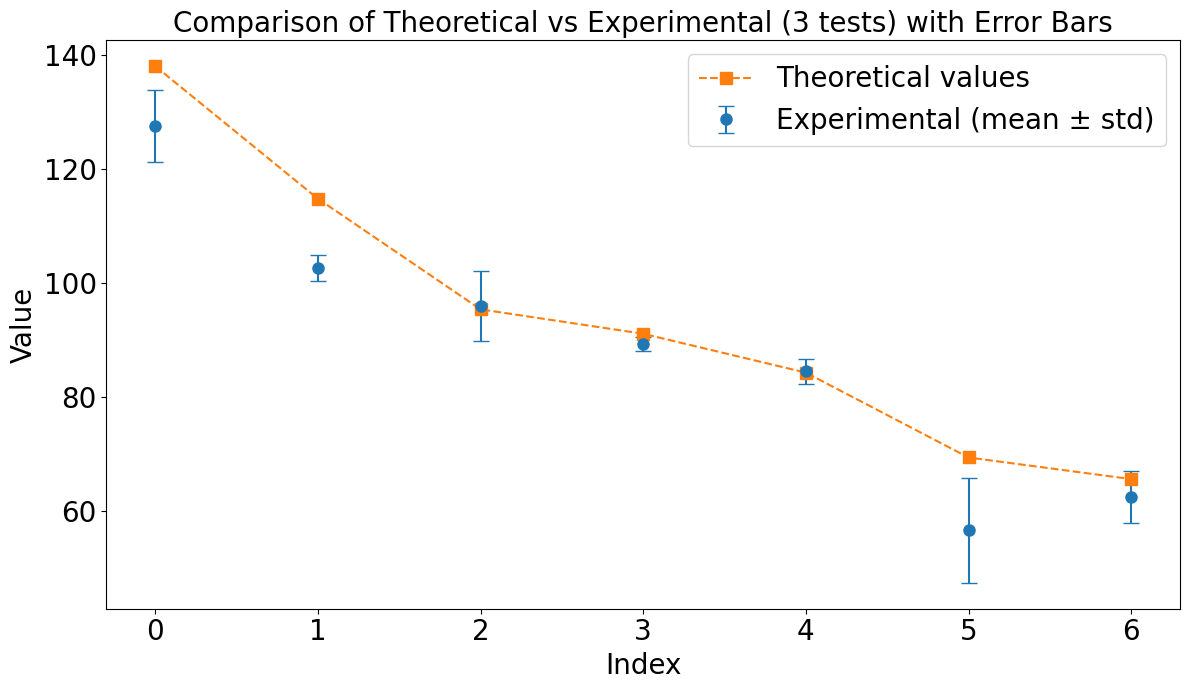

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
c_theoretical = np.array([138.07, 114.79, 95.36, 91.07, 84.24, 69.34, 65.54])
test1 = np.array([121.12, 101.83, 95.79, 87.86, 82.03, 64.29, 68.15])
test2 = np.array([125.45, 100.40, 103.49, 89.34, 87.42, 61.78, 62.15])
test3 = np.array([136.11, 105.68, 88.55, 90.84, 83.88, 43.57, 56.83])

# Absolute error
tests = np.vstack([test1, test2, test3])
mean_exp = tests.mean(axis=0)
std_exp = tests.std(axis=0)

# Plot
plt.figure(figsize=(12, 7))
plt.errorbar(
    np.arange(len(c_theoretical)),
    mean_exp,
    yerr=std_exp,
    fmt='o',
    capsize=6,
    markersize=8,
    label="Experimental (mean ± std)"
)
plt.plot(c_theoretical, 's--', markersize=8, label="Theoretical values")

# Style
plt.xlabel("Index", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.title("Comparison of Theoretical vs Experimental (3 tests) with Error Bars", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()
